In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
from matplotlib import animation, colors, rc
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker as mtick
from IPython.display import set_matplotlib_formats, HTML, Image

set_matplotlib_formats('png', 'pdf')
rc('animation', html='html5')

import numpy as np
import scipy.special as spec
import scipy.integrate as inte
import sympy as sp
from sympy import vector
sp.init_printing()

In [3]:
# Variables mathématiques
Cart = vector.CoordSysCartesian('R')

x, y = sp.symbols('x y', real=True)
r = sp.symbols('r', positive=True)
omega = sp.symbols('omega', positive = True) # Pulsation
t = sp.symbols('t', real=True) # Temps
Ic = sp.symbols('I') # Courant électrique

mu = sp.symbols("mu0", positive = True) # Perméabilité magnétique du milieu
c = sp.symbols("c", positive=True)      # Célérité de la lumière dans le milieu
k = omega/c       # relation de dispersion par défaut

# Position du problème

Étant donné un fil électrique très long parcouru par un courant électrique $i$, on cherche à déterminer le champ magnétique créé par phénomène d'induction dans l'espace autour. 

On peut le détecter en approchant une boussole, de la limaille de fer ou d'autres aimants permanents du fil, voire approcher un autre fil électrique lui aussi parcouru par un courant.

Le développement pour trouver l'expression du champ magnétique créé par un courant *constant* $I$ est classique et mène à la solution $\mathbf B(\mathbf r) = \frac{\mu_0I}{2\pi\|\mathbf r\|}\mathbf e_{\theta}$.

Ici, la question est celle d'un courant *variable* $i(t)$. On réussit à déterminer l'expression du champ créé lorsque $i$ est sinusoïdal en utilisant des potentiels retardés.

Ce cahier Jupyter développe l'implémentation en `Python` d'objets et fonctions permettant de visualiser la propagation des ondes magnétiques crées par un courant variable, avec la possibilité d'exploiter plusieurs types de visualisations et des animations.

# Implémentations en Python du champ magnétique et du courant électrique

Le courant et le champ magnétique seront représentés par des instances des classes `current` et `Field`, qui sont définies dans cette section. 

Chaque courant, par exemple, sera un objet de type `Current`, dont les attributs, tels que `frequences`, `intensites`, `expr`, `func` contiendront les caractéristiques du courant, son expression mathématique, et une fonction numérique permettant de le calculer.

## Courant électrique : classe `current`

La cellule suivante définit les courants électriques comme une classe Python `Current`.

In [135]:
class Current:
    # Composante du courant électrique de pulsation omega
    cour_component = Ic*sp.exp(sp.I*omega*t)
    
    def __init__(self, intens=None, puls=None, phas=None):
        """
        Étant donné le spectre (intensités et pulsations), 
        initialise le courant en attribuant les pulsations du courant, 
        les intensités associées.
        L'argument d'une intensité complexe correspond au déphasage 
        de la composante du courant associée.
        
        Si les phases sont précisées, elles sont ajoutées aux arguments des
        intensités."""
        if intens is not None:
            if phas is not None:
                intens = np.asarray(intens)*np.exp(1j*np.asarray(phas))
            self._spectre(intens, puls)
    
    def _spectre(self, intens, puls):
        """
        Définit la fonction numérique du courant et son expression via
        ses données spectrales, stockées dans les attributs intensites,
        pulsations, et frequences.
        Ne pas utiliser directement."""
        self.intensites = intens
        self.pulsations = np.array(puls)
        self.frequences = self.pulsations/(2*np.pi)

        spector = zip(intens,puls)
        cour = sum(self.cour_component.subs({Ic:i, omega:om}) \
                for i,om in spector)
        cour_re = sp.re(cour)
        
        cour_func = sp.lambdify((t),cour_re,modules=['numpy'])
        
        self.expr = cour_re
        self.func = cour_func
    
    @classmethod
    def from_expr(cls, expr, fs = None, N = None):
        """
        Définit la fonction numérique du courant via son expression.
        Renvoie l'objet, donc on peut définir un courant par son
        expression en écrivant
        courant = Current().expression(expr)"""
        instance = cls()
        instance.func = sp.lambdify(t, expr, modules=['numpy'])
        instance.expr = expr
        if fs is not None and N is not None:
            instance.fft(fs, N)
        return instance
        
    def fft(self, fs, N):
        """
        Calcule le spectre du courant à partir de sa fonction numérique,
        définit les attributs intensites, pulsations et frequences
        À utiliser si l'objet a été défini sans passer de données spectrales.
        fs : Fréquence d'échantillonnage
        N : taille de l'échantillon"""
        sample_time = np.linspace(-N/fs,N/fs,N+1)
        samples = self.func(sample_time)
        
        self.intensites = np.fft.rfft(samples) # Intensités
        self.pulsations = np.fft.rfftfreq(N, d=1/fs) # Pulsations associées
        self.frequences = self.pulsations/(2*np.pi)
    
    ## Méthodes de dessin
    def draw(self, tmin, tmax, N=1000, title=None):
        """
        Représentation graphique de la fonction i(t),
        stockée dans l'attribut 'self.graphe'
        
        tmin,tmax : intervalle de temps où tracer
        N : nombre de points (défaut 1000)
        custTitle : titre (facultatif)
        """
        times = np.linspace(tmin, tmax, N)
        
        fig,ax=plt.subplots(1,1,figsize=(8,5))
        ax.grid(True)
        
        if title:
            ax.set_title(title)
        else:
            ax.set_title(r"Courant électrique")
        ax.plot(times, self.func(times))
        ax.set_xlabel(r"Temps $t$ $(\mathrm{s})$")
        ax.set_ylabel(r"Intensité du courant $i$ ($A$)")
        fig.tight_layout()
        self.graphe = fig
    
    def drawfft(self):
        """
        Réprésentation graphique du spectre du courant,
        stockée dans l'attribut graphefft
        """
        fig, (ax0,ax1) = plt.subplots(2,1, figsize=(8,8))
        
        xlbl = r'Pulsation $\omega$ ($\mathrm{Hz}$)'
        
        ax0.grid(True)
        ax0.set_xlabel(xlbl)
        ax0.set_ylabel(r"Amplitude $I(\omega)$ ($\mathrm{A}$)")
        ax0.plot(self.pulsations, np.absolute(self.intensites))
        
        ax1.grid(True)
        ax1.set_xlabel(xlbl)
        ax1.set_ylabel(r"Phase $\phi(\omega)$ ($\mathrm{rad}$)")
        ax1.plot(self.pulsations, np.angle(self.intensites))
        
        ax0.set_title(r"Spectre en fréquence du courant $i(t)$")
        fig.tight_layout()
        
        self.graphefft = fig

Les objets de type `Current` représentent les courants électriques, avec des attributs et méthodes permettant de les exploiter.

Étant fournies les informations sur le spectre d'un courant (intensités des composantes harmoniques `intensites`, pulsations et phases de celles-ci `pulsations` et `phases`, représentées par des listes ou `ndarray` NumPy de mêmes dimensions), on définit sa représentation `courant` en écrivant:
```python
courant = Current(intensites, pulsations, phases)
```

Mais il n'est pas nécessaire d'avoir ces données spectrales pour définir le courant (voir plus bas).

Les attributs utiles d'un objet de type `Current` sont:
* les données spectrales (`intensites`, `pulsations`, `frequences`)
* l'expression mathématique `expr`.

Les méthodes utiles sont:
* `func`, la fonction numérique du temps $i(t)$ qui permet de calculer la valeur du courant à un instant $t$. Pour calculer la valeur du courant (représenté par l'objet `courant` ci-après) à l'instant $t= 1\,\mathrm{s}$, par exemple, on utilise
```python 
courant.func(1)
```
* `fft` qui prend en arguments une fréquence d'échantillonnage `fs` et une taille d'échantillon `N` et calcule la transformée de Fourier rapide (FFT) du signal échantillonné avec `N` points sur l'intervalle $[-N/f_s, N/f_s]$.
* la méthode de classe `from_expr`, qui prend en argument l'expression et définit la fonction du temps $i(t)$ avec, et renvoie l'objet, ce qui permet d'écrire
```python
courant = Current.from_expr(expr)
```
si de plus on précise deux paramètres `fs` et `N`, on effectue la FFT et on définit les données spectrales.
* les méthodes de dessin, à savoir
    * `draw` qui prend en argument deux instants `t0` et `t1` entre lesquels dessiner $i(t)$, avec deux arguments facultatifs `N` et `title` qui correspondent au nombre de points pour le dessin (1000 par défaut), et le titre éventuel à donner (*Courant électrique $i \,(\mathrm{A})$* par défaut)
    * `drawfft` qui ne prend pas d'arguments et dessine le spectre du courant (module $|I(\omega)|$ et phase $\varphi(\omega)$).

## Domaine spatial : classe `Domain`

In [57]:
class Domain:
    
    def __init__(self, xm, ym, J, x0=None, y0=None, eps=0):
        if x0 is None:
            x0 = -xm
        if y0 is None:
            y0 = -ym
        
        self.xm = xm
        self.x0 = x0
        self.xs = np.linspace(x0,xm,J)
        self.ym = ym
        self.y0 = y0
        self.ys = np.linspace(y0,ym,J)
        self.J = J
        
        rad = np.sqrt(self.xs**2 + self.ys**2)
        cond = rad > eps
        
        self.rad = rad[cond]
        self.grid = np.meshgrid(self.xs[cond],
                self.ys[cond])
    
    def __call__(self):
        return self.grid

Les objets de type `Domain` permettent de représenter des rectangulaires de l'espace $[x_0, x_m]\times[y_0,y_m]$.

Pour définir un domaine en connaissant $x_m$ et $y_m$, avec `I` et `J` points selon les directions $x$ et $y$ respectivement, on écrit:
```python
Omega = Domain(xm, ym, J)
```

Par défaut, le domaine est symétrisé (on prend $x_0=-y_m$ et $y_0=-y_m$). Pour au contraire préciser $x_0$ et $y_0$, il suffit de passer des arguments supplémentaires au constructeur `Domain` :
```python
Omega = Domain(xm, ym, J, x0, y0)
```
et si on veut n'en préciser qu'un seul des deux, écrire
```python
Omega = Domain(xm, ym, J, x0 = ...) ou
Omega = Domain(xm, ym, J, y0 = ...)
```
en fonction du contexte, et remplacer les pointillés par les valeurs voulues.

Si on veut exclure un disque de rayon $\varepsilon$ centré en l'origine, préciser la paramètre `eps = ...` dans l'appel à `Domain` de la même façon que pour `x0` et `y0` au-dessus.

## Champ magnétique : classe `Field`

La cellule suivante définit les champs magnétiques comme une classe Python `Field`, dont les attributs sont notamment l'expression formelle du champ (`expr`), et les fonctions numériques qui permettent de calculer le champ en un point, `orthFunc` (prenant en argument la position radiale $r$), et `orthFuncCart` et `fieldFunc` (prenant en argument les coordonnées $(x,y)$).

**Attention** Code long et pas beau.

In [105]:
class Field:
    
    def __init__(self, intens=None, puls=None, phas=None): 
        # Célérité des ondes ; à modifier en fonction du milieu
        self.cel = 3e8
        # Composante du potentiel vecteur associée à la pulsation omega
        self.A_component = sp.I*mu*Ic/4 * sp.hankel2(0,k*r)*sp.exp(sp.I*omega*t)
        # Composante du champ magnétique associée à la pulsation omega
        self.B_component = - sp.diff(self.A_component, r).simplify()

        # Conversion de fonctions formelles à fonctions numériques
        self.impl_modules = ['numpy',{"hankel2":spec.hankel2}]
        
        if intens is not None:
            if phas is not None:
                intens = np.asarray(intens)*np.exp(1j*np.asarray(phas))
            self.pulsations = np.array(puls)
            self.frequences = puls/(2*np.pi)
            
            c0 = self.cel
            mu0_v = 4e-7*np.pi

            spectral_data = zip(intens, puls)
            cmp = sp.re(self.B_component)
            
            orthExpr = sum([
                cmp.subs({Ic: cur, omega:om, c:c0, mu:mu0_v}) \
                for (cur,om) in spectral_data if (cur!=0 and om!=0) ])

            orthFunc = sp.lambdify((r, t), orthExpr, 
                modules = self.impl_modules)

            self.orthExpr = orthExpr
            self.orthFunc = orthFunc

            # Fonctions en cartésien
            rxy = sp.sqrt(x**2+y**2)

            self.orthFuncCart = sp.lambdify((x, y, t), orthExpr.subs({r:rxy}), 
                modules = self.impl_modules)
            self.fieldExpr = (-y*Cart.i + x*Cart.j)*orthExpr.subs({r:rxy})/rxy
            self.fieldFunc = sp.lambdify((x, y, t), 
                self.fieldExpr.to_matrix(Cart), 
                modules = self.impl_modules)
    
    @classmethod
    def from_current(cls, courant):
        """Définit le champ à partir d'un courant électrique."""
        instance = cls(courant.intensites, courant.pulsations)
        return instance
    
    def legende(self,t):
        """Définit la légende à donner aux graphes à l'instant t"""
        return r'$t= {:.3e}$'.format(t) + r"$\ \mathrm{s}$"
    
    def _setup_plot(self, Omega, title=None):
        radii = Omega.rad
        
        fig = plt.figure(figsize=(8,5))
        ax = plt.axes()
        ax.set_xlim((np.amin(radii), np.amax(radii)))
        ax.grid(True)
        ax.set_xlabel("Distance $r$ (m)")
        ax.set_ylabel("Valeur du champ (T)")
        
        if title:
            ax.set_title(title)
        else:
            ax.set_title(r'Champ magnétique ' + r'$\mathbf{B}$' \
                         + ' créé par un courant variable')
        
        ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))
        return fig, ax
    
    def profile(self, Omega, times, title = None):
        """
        Profil du champ magnétique aux instants de 'times'
        (fonction de la distance au fil)
        """
        func = self.orthFunc
        radii = Omega.rad
        fig,ax = self._setup_plot(Omega, title) 

        if hasattr(times, '__iter__'):
            for ti in times:
                champ = func(radii, ti).real
                ax.plot(radii, champ, label=self.legende(ti))
        else:
            champ = func(radii, times).real
            ax.plot(radii, champ, label=self.legende(times))
        ax.legend(loc='best')
        
        self.graph = fig

    
    def _setup_surface(self, Omega):
        grid, radii = Omega(), Omega.rad
        
        fig = plt.figure(2, figsize=(8,6))
        fig.suptitle(r"Champ magnétique $\mathbf{B}$")
        ax = fig.add_subplot(111, projection='3d')
        ax.grid(True)
        
        return grid,fig, ax
    
    def surfacePlot(self, Omega, t):
        """
        Portrait du champ magnétique à l'instant t (surface)
        """
        func = np.vectorize(self.orthFuncCart)
        radii = Omega.rad
        grid,fig,ax = self._setup_surface(Omega)
        
        normB = func(*Omega(), t)
        
        ax.plot_wireframe(*grid, normB)
        
        self.surf = fig
    
    def _heatFormat(self, ax):
        ax.set_xlabel(r"$x$ (m)")
        ax.set_ylabel(r"$y$ (m)")
    
    def heatPlot(self, Omega, t):
        """Représentation 2D du champ par coloration"""
        grd = Omega()
        xg, yg = grd
        J = Omega.J
        x0,y0 = Omega.x0,Omega.y0
        xm,ym = Omega.xm,Omega.ym
        func = self.orthFuncCart
        vals = func(xg, yg, t)
        cmap = "inferno"
        fig = plt.figure(figsize=(8,8))
        ax = fig.add_subplot(111)
        data = ax.imshow(vals,
            cmap = cmap,
            interpolation='sinc',
            extent=[x0,xm,y0,ym]
        )
        self._heatFormat(ax)
        bar = fig.colorbar(data)
        bar.set_label(r"Intensité du champ magnétique (T)")
        time_text = ax.text(0.5,1, self.legende(t),
            horizontalalignment='center',
            transform=ax.transAxes)
        fig.tight_layout()
        self.heatmap = fig
    
    def _animParams(self, t0, t1, animtime, fps):
        """
        Calcule les paramètres d'animation (nombre d'images,
        intervalles en temps réel et temps vidéo entre chaque image)"""
        N = int(np.ceil(fps*animtime))
        dt = (t1-t0)/N
        interval = 1000/fps
        return N, dt, interval
    
    def _window(self, valMin,valMax):
        """
        Renvoie un couple correspondant aux bornes d'un intervalle
        contenant valMin et valMax avec 20% de marge"""
        delta = np.absolute(valMax-valMin)
        return (valMin-0.2*delta,valMax+0.2*delta)
        
    def animate(self, Omega, t0, t1, animtime=10, title = None, fps=25):
        """
        Construit une animation du profil du champ
        entre les temps t0 et t1"""
        
        # Paramètres d'animation
        N,dt,interval = self._animParams(t0,t1,animtime,fps)
        
        func = self.orthFunc
        radii = Omega.rad
        grid = Omega()
        
        fig, ax = self._setup_plot(Omega, title)
    
        line, = ax.plot([], [], lw=2)
        time_text = ax.text(0.02, 0.95, '',
                            transform=ax.transAxes)
        
        record = [func(radii,t0+i*dt) for i in range(N)]
        
        # Cadrage
        ymax = np.nanmax(np.asarray(record))
        ymin = np.nanmin(np.asarray(record))
        ax.set_ylim(self._window(ymin,ymax))
        
        def init():
            line.set_data([],[])
            time_text.set_text(self.legende(t0))
            return line,
        
        def update(i):
            ti = dt*i+t0
            champ = record[i]
            line.set_data(radii, champ)
            time_text.set_text(self.legende(ti))
            return line,
        self.radiiRecord = record
        anim = animation.FuncAnimation(fig, update, init_func=init, 
                    frames=N, interval=interval, blit=True)
        self.anim = anim
        return self.anim
        
    def animate3D(self, Omega, t0, t1, animtime=10, fps=25):
        """
        t0,t1 -> intervalle [t0,t1]
        fps : nombre d'images par seconde à générer"""
        # Paramètres d'animation
        N,dt,interval = self._animParams(t0,t1,animtime,fps)
        func = np.vectorize(self.orthFuncCart)
        grid,fig,ax = self._setup_surface(Omega)
        
        # Enregistrement des valeurs du champ à afficher
        record = [func(*grid, t0+i*dt) for i in range(N)]
        self.recordSurface = record
        
        # Cadrage
        zmin = np.nanmin(np.asarray(record))
        zmax = np.nanmax(np.asarray(record))
        zlims = self._window(zmin,zmax)
        
        # Initialisation
        surf = ax.plot_wireframe(*grid, record[0])
        time_text = ax.text2D(0.5,1,self.legende(t0),
                    horizontalalignment='center',
                    transform=ax.transAxes)
        ax.set_zlim(zlims)
        
        def update(i):
            ax.clear()
            ax.set_zlim(zlims)
            ti = i*dt + t0
            champ = record[i]
            time_text = ax.text2D(0.5,1,self.legende(ti),
                    horizontalalignment='center',
                    transform=ax.transAxes)
            data = ax.plot_wireframe(*grid, champ)
            return data, time_text
        
        anim = animation.FuncAnimation(fig,update,
                        frames=N,interval=interval)
        self.surfaceAnim = anim
        return self.surfaceAnim
        
    def heatAnim(self, Omega, t0, t1, animtime=10, fps=25):
        
        x0,x1 = Omega.x0,Omega.xm
        y0,y1 = Omega.y0,Omega.ym
        cmap = 'inferno'
        func = self.orthFuncCart
        grd = Omega()
        xg,yg = grd
        N,dt,interval = self._animParams(t0,t1,animtime,fps)
        
        fig,ax = plt.subplots(1,1, figsize=(6,6))
        data = ax.imshow(func(*grd,0),
                interpolation='sinc', 
                extent=[x0,x1,y0,y1],       
                cmap=cmap)
        self._heatFormat(ax)
        time_text = ax.text(0.5,1, self.legende(0),
            horizontalalignment='center',
            transform=ax.transAxes)
        bar = fig.colorbar(data)
        bar.set_label(r"Intensité du champ magnétique (T)")
        fig.tight_layout()
        
        def animate(i, data):
            ti = i*dt+t0
            data.set_data(func(*grd,ti))
            self._heatFormat(ax)
            time_text.set_text(self.legende(ti))
            return data, time_text
        
        anim = animation.FuncAnimation(fig, animate, frames=N,
                interval=interval,
                fargs=(data,))
        self.heatanim = anim
        return self.heatanim

On définit un champ magnétique `champ` via les données spectrales du courant qui l'a créé :
```python
champ = Field(intensites, pulsations, phases)
```
avec `phases` un argument facultatif.

On peut également utiliser la méthode de classe `from_current` pour définir un champ à partir de l'objet représentant le courant, selon la syntaxe
````python
champ = Field.from_current(courant)
```
**Attention** Les données spectrales du courant doivent être définies, soit à la création de l'objet soit via la méthode `fft` !

Parmi les méthodes utiles, il y a `profile` et `surfacePlot`, qui produisent les courbes $y=B_\theta(r,t)$ et $z = B(x,y,t)$ respectivement sur un domaine à préciser à un instant à préciser, selon la syntaxe:
```python
champ.profile(Omega, t, title)
champ.surfacePlot(Omega, t)
```
avec `title` le titre à donner (défaut « Champ magnétique $\mathbf B$ créé par un courant variable »).
Si `t` est une liste de temps, les méthodes effectuent les tracés aux temps de la liste dans le même repère.

Pour produire des versions animées de ces courbes, utiliser les méthodes `animate` et `animate3D` respectivement, selon la syntaxe:
````python
champ.animate(Omega, t0, t1, animtime, title, fps)
champ.animate3D(Omega, t0, t1, animtime, fps)
```
avec `t_0`, `t_1` les instants entre lesquels il faut faire l'animation, `animtime` la durée de l'animation (défaut 10 secondes), `title` le titre à donner (même titre par défaut), `fps` le nombre d'images par seconde (défaut 25).

# Exemples d'utilisation

## Données initiales

Entrez dans la variable `freqs` les fréquences du courant voulu, et dans `phas` les phases. Exécutez la cellule (`Ctrl + Entrée` sur le clavier) pour définir la fonction de champ :

In [7]:
k = omega/c # relation de dispersion

freqs = np.array([n*1e8 for n in range(2,5)])

puls = 2*np.pi*freqs # Pulsations associées
intens = np.array([2,3,5]) # Intensités des composantes

phases = np.array([0,0.3,0.3]) # Phases des composantes

B_field = Field(intens, puls, phases)

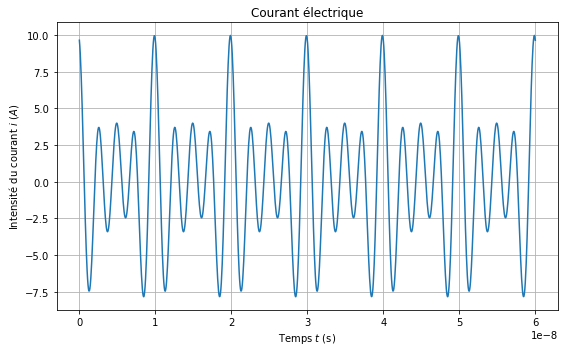

In [8]:
courant = Current(intens, puls, phases)
courant.draw(0,6e-8)

La cellule suivante définit les distances minimale et maximale pour lesquels tracer le profil du champ magnétique :

## Profil du champ

### Statique

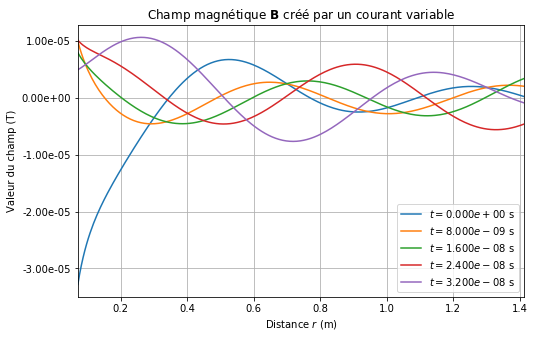

In [9]:
Omega = Domain(1,1,256, 0.05, 0.05)

times = [1e-9*8*k for k in range(5)]

B_field.profile(Omega,times)

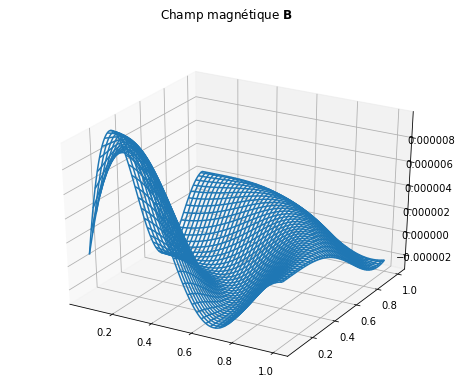

In [10]:
B_field.surfacePlot(Omega, 3.92e-8)

### Animation

On peut animer le profil du champ magnétique entre deux instants $t_0$ et $t_m$ :

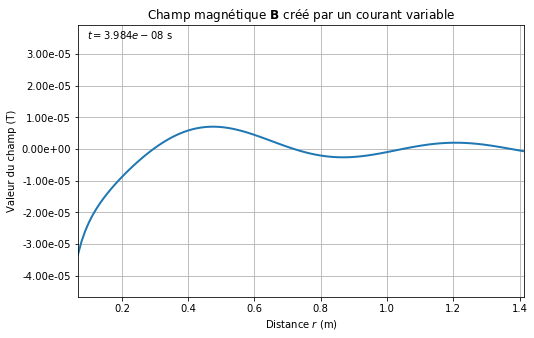

In [11]:
Omega = Domain(1,1,128, 0,0,eps=0.06)
times_an = (0, 4e-8) # (t0, t1)

B_field.animate(Omega,*times_an)

La visualisation en tant que surface ondulante:

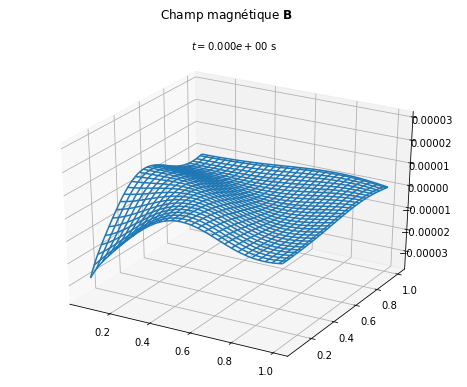

In [12]:
Omega = Domain(1,1,64,0,0,eps=0.08)
B_field.animate3D(Omega, *times_an)

# En milieu dispersif

On s'intéresse à la propagation dans un plasma. La relation de dispersion (entre vecteur d'onde $k$ et pulsation $\omega$) dans un plasma de fréquence $\omega_p$ est
$$
k^2 = \frac{\omega^2 - \omega_p^2}{c^2}
$$

Pour la démonstration, on utilisera le courant électrique suivant:

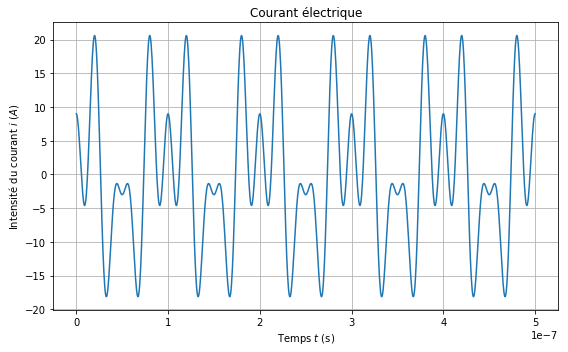

In [120]:
freqs = np.array([n*1e7 for n in range(1,6)])
puls = 2*np.pi*freqs
intens = np.array([7,-2,-9,5,8])
phas = np.array([0,0,0,0.2,0.7])
courant = Current(intens, puls)

courant.draw(0,5e-7)

On s'intéresse ici au champ induit par un courant à l'intérieur d'une gaine, qui peut être assimilée au vide, et de rayon $5 \,\mathrm m$, plongée dans un plasma de fréquence $f_p = 3.2\cdot 10^7\,\mathrm{Hz}$.

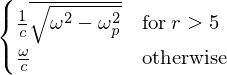

In [78]:
omegap = sp.symbols("omega_p")
pulsPlas = 2*np.pi*3.2e7
kplas = sp.conjugate(sp.sqrt(omega**2-omegap**2))/c
k = sp.Piecewise((kplas, r>5), (omega/c, True))
k

La fonction suivante définit une fonction numérique correspondant à $k(\omega)$ et en fait le tracé sur l'intervalle des pulsations du courant $i$.

In [79]:
def dispersion(puls,ra):
    """
    Fait le graphe de k = k(omega) (relation de dispersion)
    """
    wmin = np.amin(puls)
    wmax = np.amax(puls)
    wrange = np.linspace(wmin,wmax, 256)
    
    func = sp.lambdify((omega,c,r), k.subs({omegap:pulsPlas}), "numpy")
    krange = func(wrange+0j, 3e8, ra)
    
    fig,ax = plt.subplots(1,1, figsize=(8,5))
    fig.suptitle(r"Relation de dispersion $k=k(\omega)$ à $r={}$".format(ra) \
                + " $\mathrm{m}$")
    
    ax.grid(True)
    ax.plot(wrange, krange.real, 'r', label=r"$\mathrm{Re}\, k(\omega)$")
    ax.plot(wrange, krange.imag, label=r"$\mathrm{Im}\, k(\omega)$")
    ax.set_xlabel(r"Pulsation $\omega$")
    ax.legend()
    return func

<function numpy.<lambda>>

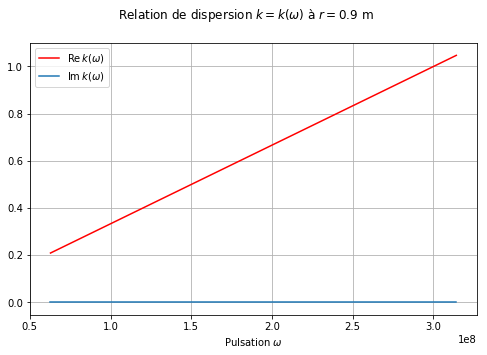

In [80]:
dispersion(puls, 0.9)

<function numpy.<lambda>>

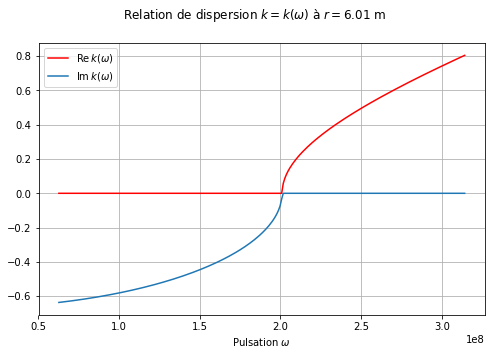

In [81]:
dispersion(puls, 6.01)

## Profil du champ

In [106]:
k = k.subs({omegap:pulsPlas})
plasmaField = Field.from_current(courant)

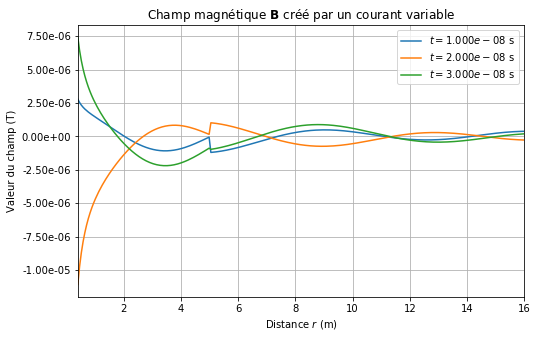

In [107]:
rmin = 0.4
rmax = 16
xmin, xmax = rmin/2**0.5, rmax/2**0.5

Omega = Domain(xmax,xmax,256,xmin,xmin)

plasmaField.profile(Omega,[1e-8,2e-8, 3e-8])

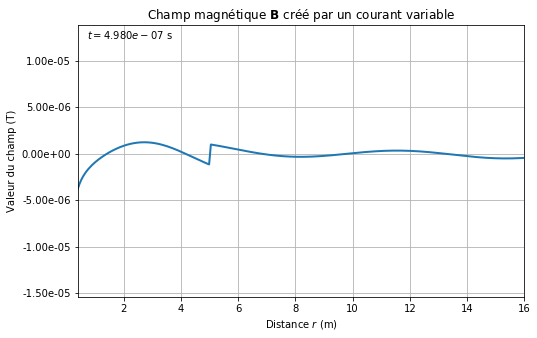

In [84]:
plasmaField.animate(Omega, 0,5e-7)

## *Heatmap*

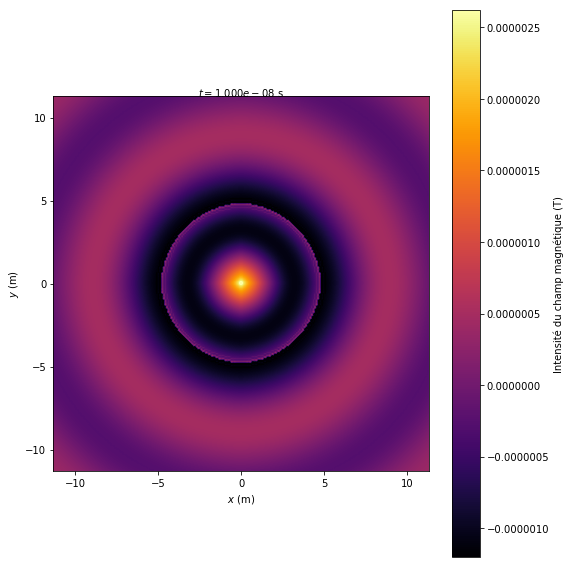

In [115]:
rmin = 0.4
rmax = 16
xmin, xmax = rmin/2**0.5, rmax/2**0.5
Omega = Domain(xmax,xmax,256, eps=rmin)
plasmaField.heatPlot(Omega, 1e-8)

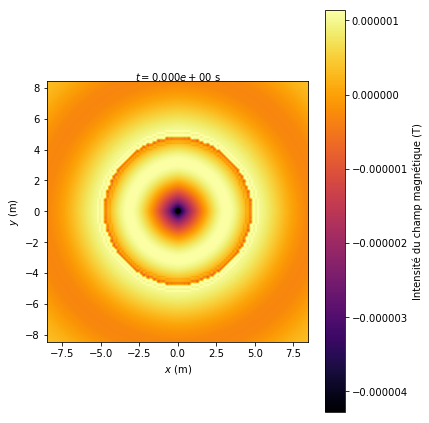

In [111]:
Omega = Domain(xmax,xmax,128, eps=rmin)
plasmaField.heatAnim(Omega, 0, 8e-8)

## Surface

In [103]:
rmin = 0.4
rmax = 10
xmin, xmax = rmin/2**0.5, rmax/2**0.5
Omega = Domain(xmax,xmax,64,xmin,xmin)

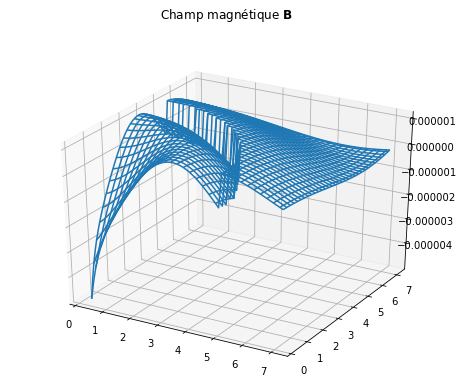

In [104]:
plasmaField.surfacePlot(Omega,0)

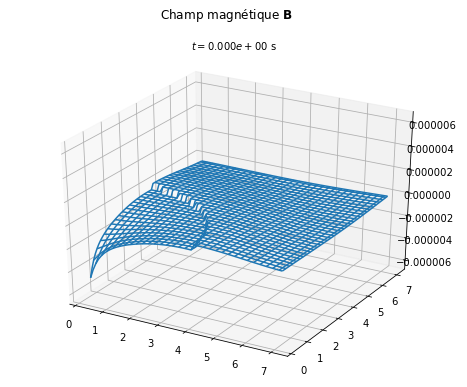

In [45]:
plasmaField.animate3D(Omega,0,5e-7)

# Exemple d'application: Paquet d'ondes

On cherche à simuler le champ créé par des impulsions sinusoïdales de courant dans le fil électrique, de la forme
$$
i(t) = I_0\exp\left(-\frac{t^2}{2\tau^2}\right)\cos\left(\frac{t}{\tau}\right)
$$
avec $\tau$ l'étendue de l'impulsion, de l'ordre de la dizaine de picosecondes ($\approx 10^{-11}$ secondes).

Pour définir un courant `Current` via son expression, il suffit d'initialiser un objet de classe `Current` en écrivant `out = Current()` par exemple, puis en utilisant la méthode `_expr` avec l'expression en argument.

In [170]:
def gaussienne(tau):
    ex = sp.exp(-t**2/(2*tau**2))*sp.cos(10*t/tau)
    out = Current.from_expr(ex)
    return out

In [218]:
courant = gaussienne(5e-11)

Graphe:

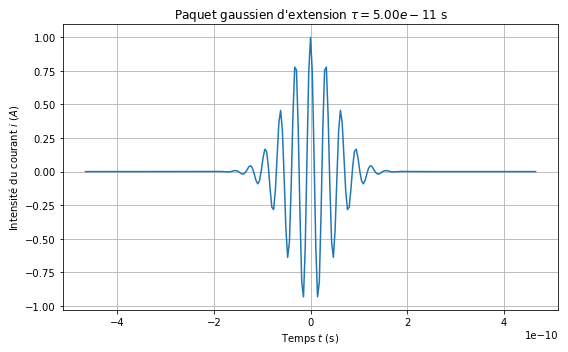

In [268]:
N = 2**8 # Nombre d'échantillons
fs = 2**39 # Fréquence d'échantillonnage

titros = r"Paquet gaussien d'extension $\tau = {:.2e}$ s".format(5e-11)
courant.draw(-N/fs,N/fs, N+1, titros)

Construction du spectre du courant via la méthode `fft`:

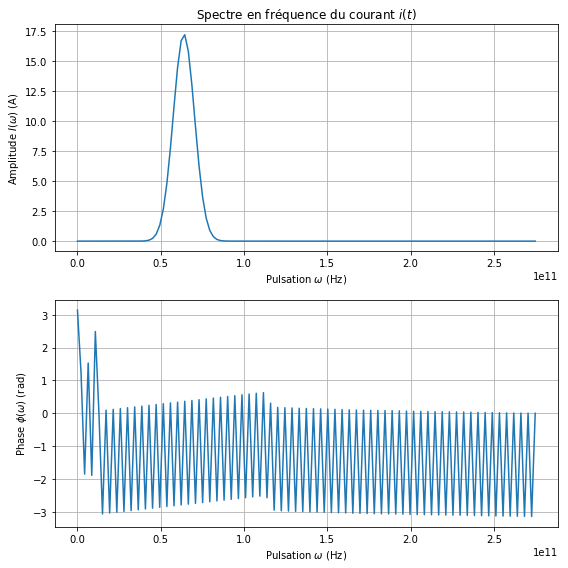

In [269]:
courant.fft(fs, N)
courant.drawfft()

In [270]:
k = omega/c

reponseImpulsion = Field.from_current(courant)

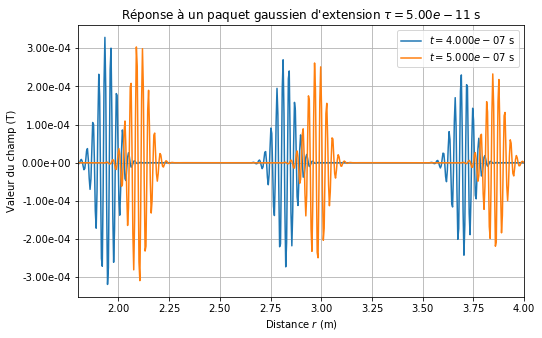

In [281]:
rmin = 1.8
rmax = 4
xmin = rmin/2**0.5
xmax = rmax/2**0.5

Omega = Domain(xmax,xmax,512,x0=xmin,y0=xmin)

times = [1e-7*k for k in [4,5]]
titre_gauss = "Réponse à un paquet gaussien d'extension " + \
        r"$\tau={:.2e}$".format(5e-11) + " $\mathrm{s}$"
reponseImpulsion.profile(Omega, times, title=titre_gauss)

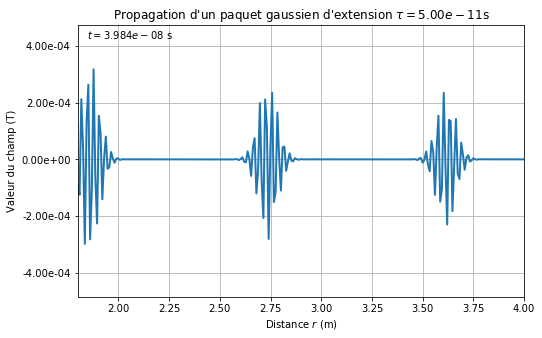

In [288]:
Omega = Domain(xmax,xmax,256,x0=xmin,y0=xmin)
temps = (0,4e-8)
titre = "Propagation d'un paquet gaussien d'extension " + \
            r"$\tau = {:.2e}$".format(5e-11) + \
            "$\mathrm{s}$"
reponseImpulsion.animate(Omega,*temps, title=titre)

# Paquet d'onde en milieu dispersif

On reprend la relation de dispersion d'avant:

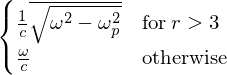

In [282]:
pulsPlas = 0.7e11
kplas = sp.conjugate(sp.sqrt(omega**2-omegap**2))/c
k = sp.Piecewise((kplas, r>3), (omega/c, True))
k

<function numpy.<lambda>>

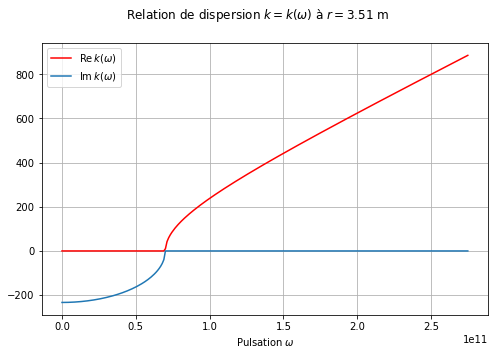

In [283]:
dispersion(courant.pulsations,3.51)

In [284]:
k = k.subs({omegap:pulsPlas})
plasmaGauss = Field.from_current(courant)

On voit bien comment le plasma, dans la zone $r>3\mathrm m$, détruit le paquet d'onde.

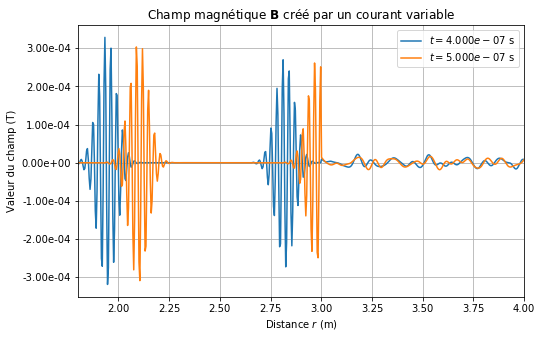

In [286]:
rmin = 1.8
rmax = 4
xmin = rmin/2**0.5
xmax = rmax/2**0.5

Omega = Domain(xmax,xmax,512,xmin,xmin)
plasmaGauss.profile(Omega, [4e-7,5e-7])

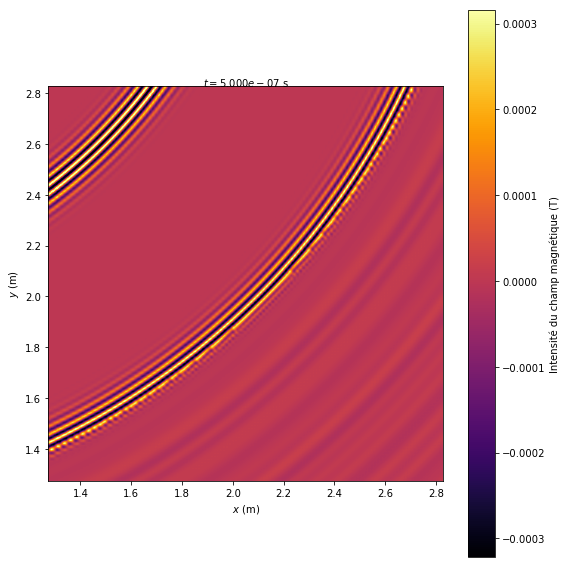

In [287]:
Omega = Domain(xmax,xmax,128,xmin,xmin)
plasmaGauss.heatPlot(Omega,5e-7)

In [ ]:
plasmaGauss.heatAnim(Omega,1e-7,8e-7)

# Théorie

Le champ magnétique $\mathbf{B}$ dérive d'un champ $\mathbf A$ appelé *potentiel vecteur* : $\mathbf{B} = \nabla\wedge\mathbf{A}$. On applique la jauge de Lorenz
\begin{equation}
\nabla\cdot\mathbf{A} + \frac{1}{c^2}\frac{\partial V}{\partial t} = \mathbf{0}
\end{equation}
où $V$ est le potentiel électrique. Par argument de symétrie cylindrique, on montre que $\mathbf A(\mathbf r,t) = A(x,y,t)\mathbf e_z$.

Le potentiel vecteur $\mathbf{A}$ est solution de l'équation d'onde
$$\begin{equation}
\Delta\mathbf A  - \frac{1}{c^2}\frac{\partial^2\mathbf A}{\partial t^2} = - \mu_0\mathbf{J}(r,t),
\end{equation}$$
avec $\mathbf J(\mathbf r,t)  = i(t)\delta(\mathbf r_\perp)\mathbf{e}_z$ la densité volumique de courant, de sorte que pour toute surface $(\Sigma)$ traversée par le fil, on ait que le flux de $\mathbf J$ soit égal au courant parcourant le fil : $\iint_{(\Sigma)}\mathbf J(\mathbf r,t)\cdot\,\mathrm d\boldsymbol \sigma = i(t)$.

Pour un courant sinusoïdal $i(t) = Ie^{i\omega t}$, la densité volumique de courant s'écrit $\mathbf J(\mathbf r,t) = -\delta(\mathbf r_\perp)Ie^{i\omega t}\mathbf e_z$. En écrivant $A(\mathbf r,t) = A(\mathbf r)e^{i\omega t}$, l'EDP se réduit à l'équation d'Helmholtz en deux dimensions:
$$\begin{equation}
\Delta_\perp A(\mathbf r) + k^2A(\mathbf r) = -\mu_0I\delta(\mathbf r_{\perp})
\end{equation}$$

Sa solution est $\mu_0I$ fois la fonction de Green associée[^fn1]:
$$
A(\mathbf r) = i\frac{\mu_0 I}{4}H_0^{(2)}(kr)
$$
(en coordonnées cylindriques), où $H_0^{(2)}$ est la fonction d'Hankel de la deuxième espèce d'ordre 0.

[^fn1]: Couto, *Green’s functions for the wave, Helmholtz and Poisson equations in a two-dimensional boundless domain* http://www.scielo.br/pdf/rbef/v35n1/v35n1a04.pdf